# Coiled Failcase for using xhistogram on cmip6 data

## What am I trying to achieve here

I would like to compute a joint distribution (2D histogram) of ocean volume based on values of temperature `thetao` and salinity `so`. 
This requires to take the histogram over the 3 spatial dimensions of e.g. ocean model output (`x`, `y`, and `lev`), preserving the `time` dimension.

The following function is a simple wrapper around `histogram` that provides some inputs (with hardcoded names used for my particular dataset).

Importantly the histogram is weighted by the volume of the cells, so it represents the total volume of the ocean found in a certain bin-combo of temperature and salinity.

In [1]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()

# scale up the cluster
cluster.scale(20)
# cluster.adapt(minimum=2, maximum=10)  # or  to a fixed size.
cluster

# from dask_gateway import Gateway

# gateway = Gateway()

# # set env variables
# options = gateway.cluster_options()

# env = {
# #     "DASK_DISTRIBUTED__SCHEDULER__WORK_STEALING": False,
# #     "DASK_DISTRIBUTED__SCHEDULER__ALLOWED_FAILURES": 5,
#     "DASK_DISTRIBUTED__WORKER__MEMORY__SPILL":"None",
# }
# options.environment = env
# cluster = gateway.new_cluster(options)

# # scale up the cluster
# cluster.scale(10)
# # cluster.adapt(minimum=2, maximum=10)  # or  to a fixed size.
# cluster

In [3]:
client = cluster.get_client()

# import distributed

# def patch_spilling_off(dask_worker: distributed.Worker):
#     assert len(dask_worker.data) == 0, "Can only patch spilling when no data is stored on the worker"
#     dask_worker.data = dict()
#     dask_worker.memory_spill_fraction = None

# client.run(patch_spilling_off)

client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.747c350f1bbd4b0991c2692ccf620877 Dashboard: /services/dask-gateway/clusters/prod.747c350f1bbd4b0991c2692ccf620877/status,Cluster Workers: 8 Cores: 16 Memory: 68.72 GB


In [4]:
from xhistogram.xarray import histogram
import xarray as xr
import numpy as np
import dask.array as dsa
from dask.distributed import performance_report

## Main Tweaking parameters

In [5]:
n_bins=1000 # the number of bins (for each variable). Determines the output chunk size
ct = 1 #chunking along the time dimension (which is preserved in the computation). This determines the size of the input chunks
# do we need to chunk smaller?
# cz=20
cz=20

In [118]:
def pdf_wrapper(ds, bins_dict={'thetao':np.linspace(-1, 1, n_bins), 'so':np.linspace(-1, 1, n_bins)}, dim=['x', 'y', 'lev']):
    
    variables = list(bins_dict.keys())
    
    missing_vars = [var for var in variables if var not in ds.data_vars]
    if len(missing_vars) > 0:
        raise ValueError(f'Bins defined for {missing_vars} in `bins_dict` could not be found in dataset variables {list(ds.data_vars)}')
    
        
    ds = ds.squeeze()
    args = tuple([ds[v] for v in variables])
    bins = [bins_dict[v] for v in variables]
    bin_names = [v+'_bin' for v in variables]
    
    vol = ds.areacello * ds.thkcello

#     hist = histogram(*args, bins=bins, weights=vol, dim=dim)
    hist = histogram(*args, bins=bins, dim=dim)
    pdf = hist
    return pdf

In [119]:
# lets create an artificial dataset for testing (this is on the lower end of resolutions for the CMIP6 data)

# nx,ny,nz,nt = 360, 291, 45, 1980
nx,ny,nz,nt = 10, 10, 10, 10
# first try it with consistent chunk sizes (the actual datases can have slightly different time chunks)
cx,cy = nx, ny

with dask.annotate(priority=-10):
    so = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
    thetao = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
    areacello = xr.DataArray(dsa.random.random([nx,ny], chunks=[cx,cy]), dims=['x', 'y'])
    thkcello = xr.DataArray(dsa.random.random([nx,ny,nz,nt], chunks=[cx,cy,cz,ct]), dims=['x', 'y', 'lev', 'time'])
    llon, llat = np.meshgrid(np.linspace(0,360, nx), np.linspace(-90,90, ny), indexing='ij')
    lon = xr.DataArray(llon, dims=['x','y'])
    lat = xr.DataArray(llat, dims=['x','y'])


    ds_synth = xr.Dataset({'thetao':thetao, 'so':so})
    ds_synth = ds_synth.assign_coords(areacello=areacello, thkcello=thkcello, lon=lon, lat=lat)

# ds_synth = 
ds_synth

<xarray.Dataset>
Dimensions:    (lev: 10, time: 10, x: 10, y: 10)
Coordinates:
    areacello  (x, y) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    thkcello   (x, y, lev, time) float64 dask.array<chunksize=(10, 10, 10, 1), meta=np.ndarray>
    lon        (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0 360.0
    lat        (x, y) float64 -90.0 -70.0 -50.0 -30.0 ... 30.0 50.0 70.0 90.0
Dimensions without coordinates: lev, time, x, y
Data variables:
    thetao     (x, y, lev, time) float64 dask.array<chunksize=(10, 10, 10, 1), meta=np.ndarray>
    so         (x, y, lev, time) float64 dask.array<chunksize=(10, 10, 10, 1), meta=np.ndarray>

In [120]:
with dask.annotate(priority=-5):
    out = pdf_wrapper(ds_synth).to_dataset(name='test')
out

<xarray.Dataset>
Dimensions:     (so_bin: 999, thetao_bin: 999, time: 10)
Coordinates:
  * thetao_bin  (thetao_bin) float64 -0.999 -0.997 -0.995 ... 0.995 0.997 0.999
  * so_bin      (so_bin) float64 -0.999 -0.997 -0.995 ... 0.995 0.997 0.999
Dimensions without coordinates: time
Data variables:
    test        (time, thetao_bin, so_bin) int64 dask.array<chunksize=(1, 999, 999), meta=np.ndarray>

In [107]:
# out.test.isel(time=0).plot()

In [38]:
# Set up pangeo scratch bucket
import os
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']
# -> gs://pangeo-scratch/<username>
import fsspec
mapper_short = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-short.zarr')
mapper_full = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-full.zarr')
mapper_full_nospill = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_2d_xhistogram-full-nospill.zarr')

## performance report for the whole thing

In [25]:
# with performance_report(filename="2d-histogram-dask-report-full.html"):
#     out.to_zarr(mapper_full, mode='w')

## Check scaling

Look at memory use and time needed for saving subsets (in time) of the dataset

In [13]:
# Lets try this without task fusion
import dask
with dask.config.set({"optimization.fuse.active": False}):
    for ti in [2000]: #100, 500, 1000, 1500, 
        print(f"{ti} Timesteps")
    #     with performance_report(filename=f"2d-histogram-dask-report-short-{ti}.html"):
        %time out.isel(time=slice(0,ti)).to_zarr(mapper_short, mode='w')

2000 Timesteps


KeyboardInterrupt: 

Generally this seems like it has less memory pressure. The smaller datasets are not as fast, but that is not as important for me. For the higher timesteps the times seem very similar.
Most importantly, for the full dataset, this looks a lot better.

In [ ]:
for ti in [2000]: #100, 500, 1000, 1500, 
    print(f"{ti} Timesteps")
#     with performance_report(filename=f"2d-histogram-dask-report-short-{ti}.html"):
    %time out.isel(time=slice(0,ti)).to_zarr(mapper_short, mode='w')

This seems to scale really well, but then at 1500 timesteps, the memory starts ballooning. 
2000 timesteps takes really long and the memory is maxing out.

# priority stuff

In [121]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.747c350f1bbd4b0991c2692ccf620877 Dashboard: /services/dask-gateway/clusters/prod.747c350f1bbd4b0991c2692ccf620877/status,Cluster Workers: 20 Cores: 40 Memory: 171.80 GB


In [122]:
out2 = out.test.data.map_blocks(lambda x: np.empty((0,0,0)))

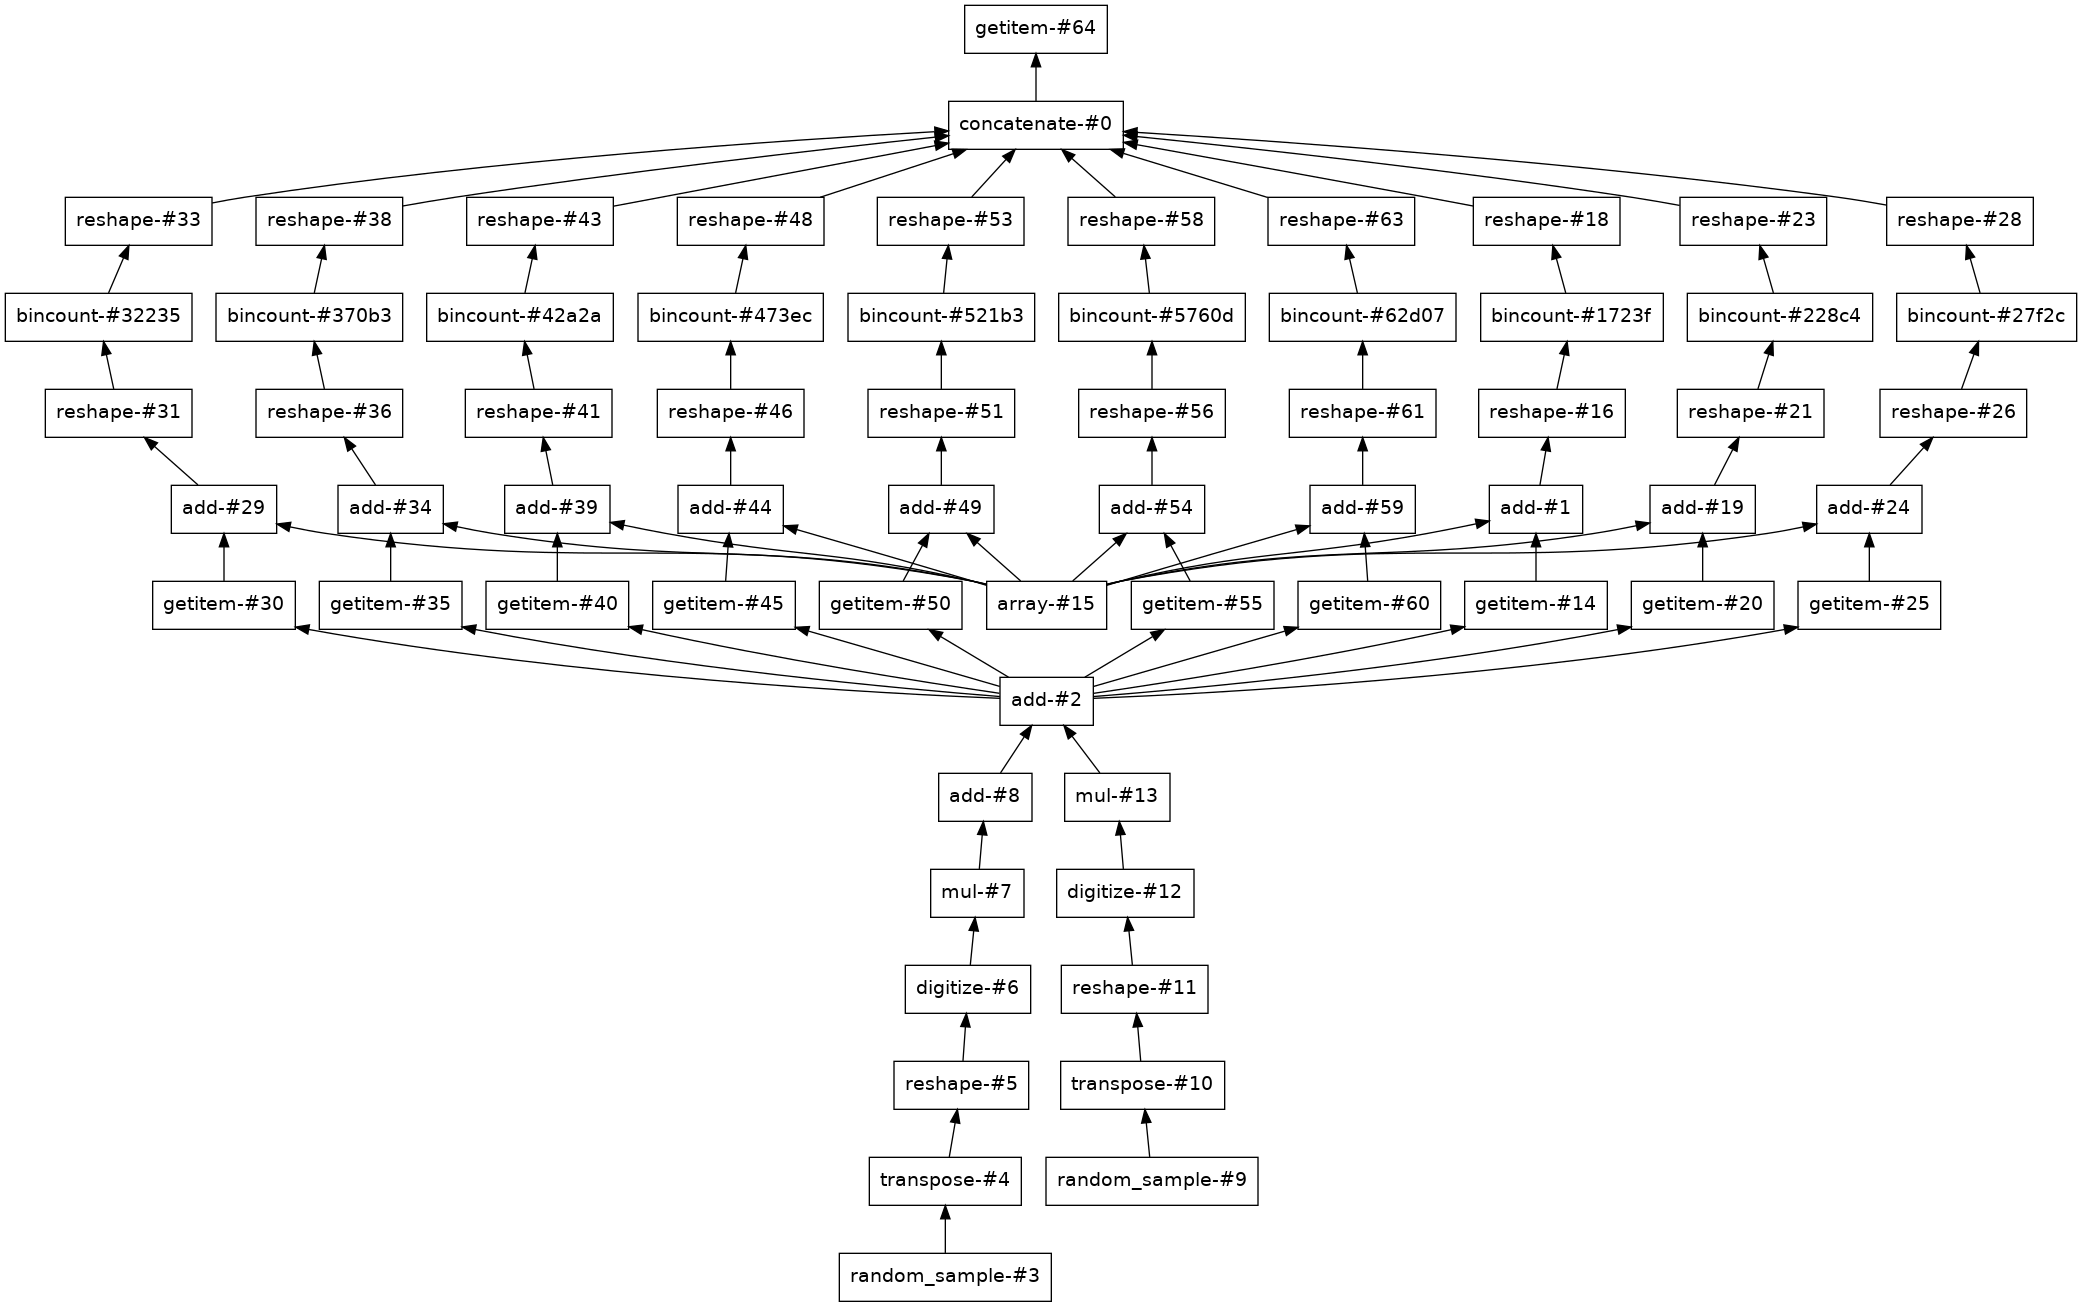

In [124]:
out.test.data.dask.visualize(format='png') #, optimize_graph=True
# out2.dask.visualize(format='png') #, optimize_graph=True

In [110]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.747c350f1bbd4b0991c2692ccf620877 Dashboard: /services/dask-gateway/clusters/prod.747c350f1bbd4b0991c2692ccf620877/status,Cluster Workers: 20 Cores: 40 Memory: 171.80 GB


In [111]:
out2.compute()

KeyboardInterrupt: 

In [48]:
# with dask.annotate(priority=10):
# out.to_zarr(mapper_short, mode='w')
zs = out.to_zarr(mapper_short, mode='w', compute=False)

In [50]:
zs.__dask_keys__()

['_finalize_store-85b1d532-35b2-4671-8c2f-0401b75fb9b3']

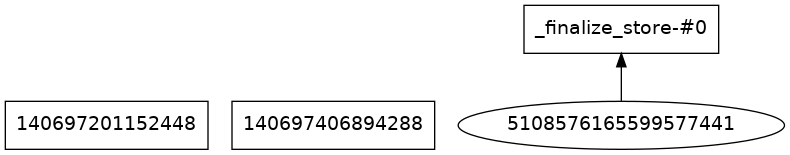

In [53]:
zs.dask.visualize(format='png')

In [56]:
ds

NameError: name 'ds' is not defined

In [66]:
g = out.__dask_graph__().visualize()

Signature: g.visualize(filename='dask.pdf', format=None, **kwargs)
Docstring: <no docstring>
Source:   
    def visualize(self, filename="dask.pdf", format=None, **kwargs):
        from .dot import graphviz_to_file

        g = to_graphviz(self, **kwargs)
        return graphviz_to_file(g, filename, format)
File:      /srv/conda/envs/notebook/lib/python3.8/site-packages/dask/highlevelgraph.py
Type:      method


In [ ]:
#()#format='png', optimize_graph=True